In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

from pathlib import Path
from hydra import initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import tqdm
import torch
import matplotlib.pyplot as plt

from tbfm import film
from tbfm import multisession

DATA_DIR = "/home/mmattb/Projects/opto-coproc/data"
sys.path.append(DATA_DIR)
# imported from JNE project
import dataset
meta = dataset.load_meta(DATA_DIR)

OUT_DIR = "data"  # Local data cache; i.e. not reading from the opto-coproc folder.
EMBEDDING_REST_SUBDIR = "embedding_rest"

conf_dir = Path("./conf").resolve()

# Initialize Hydra with the configuration directory
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml

DEVICE = "cuda:0" #cfg.device
WINDOW_SIZE = cfg.data.trial_len
NUM_HELD_OUT_SESSIONS = cfg.training.num_held_out_sessions

In [2]:
# Okay, now a stim data loader...
d, held_out_session_ids = multisession.load_stim_batched(                                                             
    batch_size=20000,                                                               
    window_size=WINDOW_SIZE,                                                               
    session_subdir="torchraw",                                                     
    data_dir=DATA_DIR,
    # held_in_session_ids=["MonkeyG_20150914_Session1_S1", "MonkeyG_20150915_Session2_S1"],
    # held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1", "MonkeyG_20150917_Session1_M1"],
    held_in_session_ids=["MonkeyG_20150925_Session2_S1"],
    num_held_out_sessions=NUM_HELD_OUT_SESSIONS,                                                      
)
data_train, data_test = d.train_test_split(5000, test_cut=2500)

held_in_session_ids = data_train.session_ids

# Gather cached rest embeddings...
embeddings_rest = multisession.load_rest_embeddings(held_in_session_ids, device=DEVICE)

In [3]:
# Customize cfg here...

# Ablations
# cfg.tbfm.module.use_film_bases = False

# cfg.tbfm.module.num_bases = 12
# cfg.tbfm.training.lambda_fro = 0.05
# cfg.tbfm.module.latent_dim = 2
# cfg.tbfm.module.basis_depth = 2
cfg.latent_dim = 60
cfg.training.grad_clip = 1000

# cfg.ae.training.coadapt = False
# cfg.ae.warm_start_is_identity = True

# cfg.normalizers.module._target_ = "tbfm.normalizers.ScalerZscore"

# Now build...
ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!


In [4]:
# Cleared for takeoff...
embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=10001)

---- 0 1.2144548892974854 0.8155079483985901 -0.18145591020584106 -0.003746016649529338
---- 1000 0.41055262088775635 0.25271546840667725 0.6005577445030212 0.6873230934143066
---- 2000 0.3914046287536621 0.24547918140888214 0.6191732883453369 0.6962717771530151
---- 3000 0.3848409354686737 0.24289940297603607 0.6255626678466797 0.6994446516036987
---- 4000 0.3809647858142853 0.2430189549922943 0.6293363571166992 0.6992846131324768
---- 5000 0.3786281943321228 0.24301770329475403 0.6316107511520386 0.6992765069007874
---- 6000 0.37446412444114685 0.24163216352462769 0.6356635093688965 0.7009860277175903
---- 7000 0.372018039226532 0.24205881357192993 0.6380435824394226 0.7004519104957581
---- 8000 0.36960819363594055 0.24235141277313232 0.6403883099555969 0.7000837922096252
---- 9000 0.3703429698944092 0.24455177783966064 0.6396732330322266 0.6973546147346497
---- 10000 0.36611104011535645 0.24413548409938812 0.6437908411026001 0.697865903377533
Final: 0.24413548409938812 0.69786590337

In [5]:
print(results["final_test_r2s"])

{'MonkeyG_20150925_Session2_S1': tensor(0.6809, device='cuda:1')}


In [ ]:
# Single session ablations, 10k epochs:
# ('0.005', '18', '70', '15.0') 
# Above, but no FiLM: 
# No FiLM and 12 bases: 
# No FiLM, 12 bases, lambda 0.05: 
# No FiLM, 12 bases, lambda 0.005, d/w 2: 
# No FiLM, 12 bases, lambda 0.005, latent_dim 60: 
# No FiLM, 12 bases, lambda 0.005, latent_dim 60, clip grad 1k: 
# No FiLM, 12 bases, lambda 0.005, clip grad 1k: 
# No FiLM, 12 bases, lambda 0.005, clip grad 1k, identity AE: 
# No FiLM and use original paper settings, but still median-based scoring: 
# Okay now z-score instead of median scoring. This is the original paper but with adaptable linear AEs. 
# Okay now z-score instead of median scoring, and fixed identity AE. 0.005 fro: 0.680910050868988
# Okay now z-score instead of median scoring, and fixed identity AE. This is closest to the original paper: 0.6941492557525635

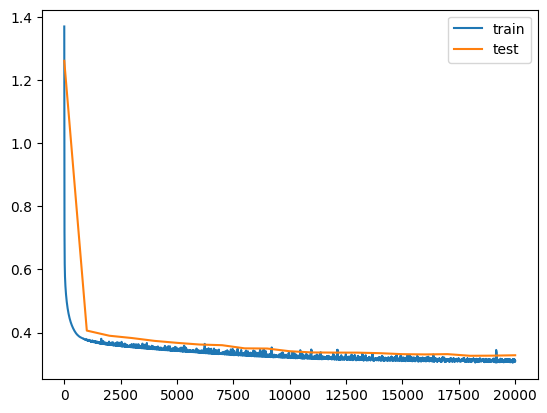

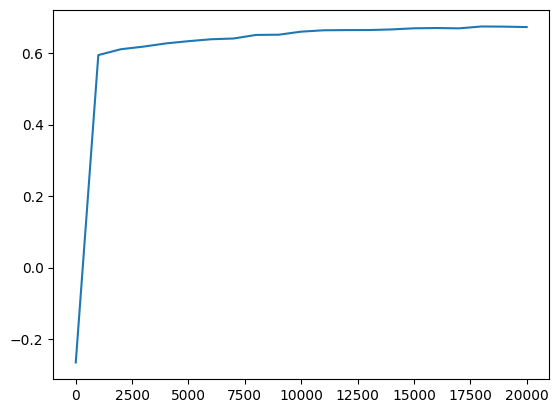

In [6]:
plt.plot(results["train_losses"], label="train")

tx = [t[0] for t in results['test_losses']]
tl = [t[1] for t in results['test_losses']]
plt.plot(tx, tl, label="test")
plt.legend()
plt.show()

tr = [t[1] for t in results['test_r2s']]
plt.plot(tx, tr)
plt.show()

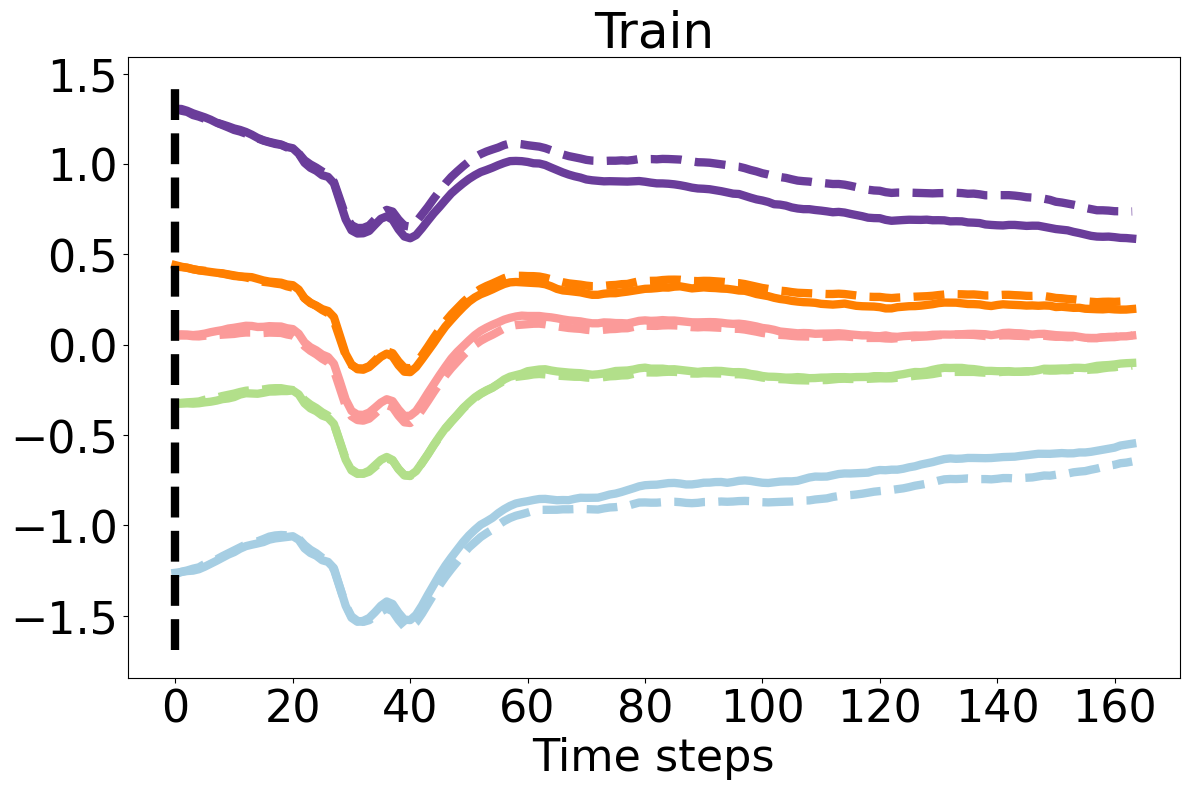

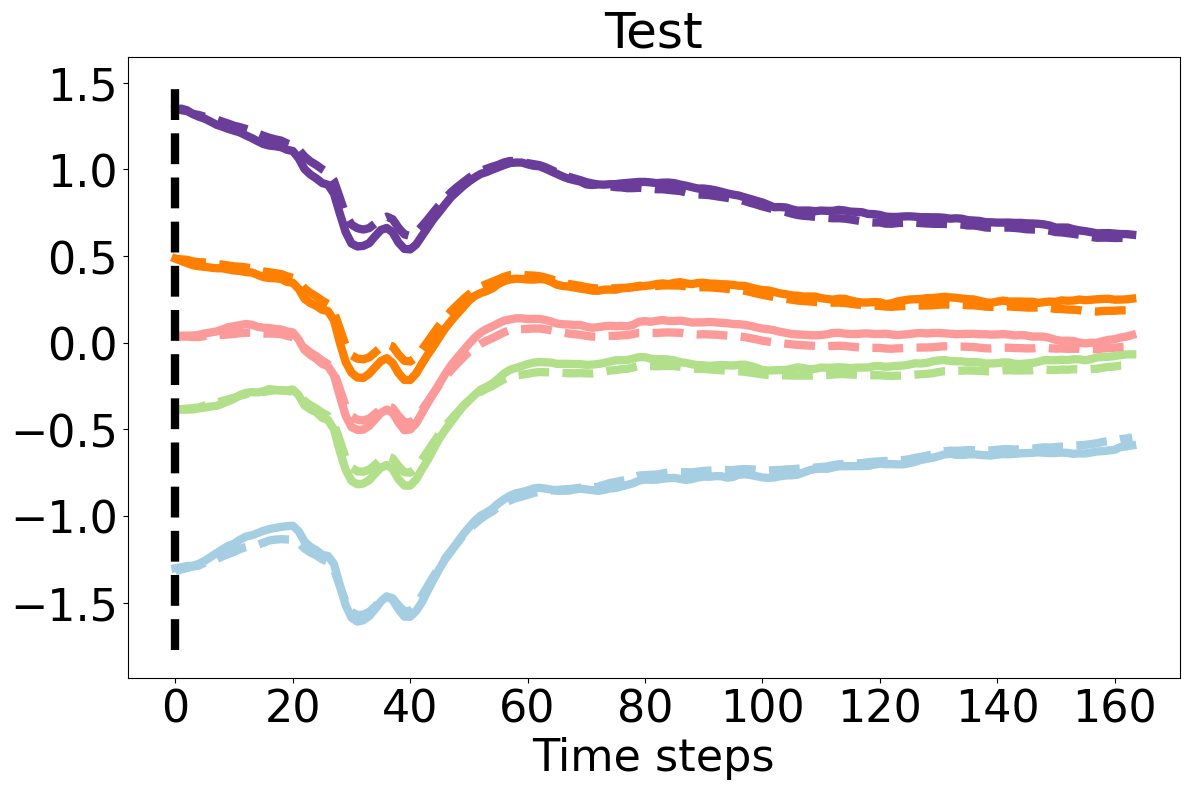

In [7]:
def graph_for_sid(sid, results, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()
    
    # y_hat_mean = torch.mean(y_hats, dim=0)
    # y_hat_test_mean = torch.mean(y_hats_test, dim=0)
    # y_mean = torch.mean(y, dim=0)
    # y_test_mean = torch.mean(y_test, dim=0)
    
    # bidx = 1000
    
    # plt.plot(y_hat_test_mean[:, cidx], label="hat")
    # plt.plot(y_test_mean[RUNWAY:, cidx], label="y")
    # plt.legend()
    # plt.show()
    test.graph_state_dependency(y, y_hats, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, title="Test", runway_length=0, ch=cidx)

graph_for_sid('MonkeyG_20150925_Session2_S1', results, cidx=30)


In [ ]:
# Try:
# * regweight = 0.01, 0.02, 0.05, 0.07, 0.1
# * num bases = 10, 12, 15, 17, 20
# * latent dim = 20, 30, 50, 70
# * grad_clip = (1.0, 10.0)

for regweight in (0.01, 0.02, 0.05, 0.07, 0.1):
    for num_bases in (10, 12, 15, 17, 20):
        for latent_dim in (20, 30, 50, 70):
            for grad_clip in (1.0, 10.0):
                print("---------------", regweight, num_bases, latent_dim, grad_clip)
    
                cfg.tbfm.training.lambda_fro = regweight
                cfg.tbfm.module.num_bases = num_bases
                cfg.latent_dim = latent_dim
                cfg.tbfm.module.use_film_bases = True
                cfg.ae.training.coadapt = True
    
                ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
                model_optims = multisession.get_optims(cfg, ms)
                
                embeddings_stim, results = multisession.train_from_cfg(
                    cfg,
                    ms,
                    data_train,
                    model_optims,
                    embeddings_rest,
                    data_test=data_test,
                    test_interval=1000,
                    epochs=12001,
                    grad_clip=grad_clip
                    )
                torch.save(results, f"res_{regweight}_{num_bases}_{latent_dim}_{grad_clip}.torch")

                del model_optims, ms

--------------- 0.01 10 20 1.0
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 0.8581539392471313 0.14049498736858368
---- 1000 0.4228585362434387 0.5773753523826599
---- 2000 0.40967828035354614 0.5906230807304382
---- 3000 0.4043762981891632 0.5959456562995911
---- 4000 0.4011189341545105 0.599209725856781
---- 5000 0.3981289267539978 0.602204442024231
---- 6000 0.39621487259864807 0.6041215062141418
---- 7000 0.39413413405418396 0.6062058210372925
---- 8000 0.3921297788619995 0.6082128882408142
---- 9000 0.39057543873786926 0.6097681522369385
---- 10000 0.3888055682182312 0.6115407347679138
---- 11000 0.38717976212501526 0.6131691336631775
---- 12000 0.387018620967865 0.6133358478546143
Final: 0.387018620967865 0.6133358478546143
--------------- 0.01 10 20 10.0
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 0.8941546082496643 0.10415659844875336
---- 1000 0.42

In [ ]:
d = "hypers_narrow"
f = [os.path.join(d, _f) for _f in os.listdir(d) if _f.startswith("res_") and _f.endswith(".torch")]
res = []
for _f in f:
    r = torch.load(_f)
    res.append((r["final_test_r2"], _f))
res.sort()

for rr in res[-10:]:
    print(rr)

# Dim = 50 or 70; let's try 60 too.
# num_bases in {10,20} that's quite a range
# 0.01 frobenius norm
# Edge to 10.0 grad norm
# Let's sample in closer to those values and get multiple 
# [(0.6266413927078247, 'res_0.01_10_70_1.0.torch'),
#  (0.6285037994384766, 'res_0.01_17_70_1.0.torch'),
#  (0.6323292851448059, 'res_0.01_15_50_1.0.torch'),
#  (0.6324095129966736, 'res_0.01_12_50_1.0.torch'),
#  (0.6349268555641174, 'res_0.01_10_70_10.0.torch'),
#  (0.635103702545166, 'res_0.01_12_70_1.0.torch'),
#  (0.6353448629379272, 'res_0.01_20_50_1.0.torch'),
#  (0.6360984444618225, 'res_0.01_10_50_1.0.torch'),
#  (0.6367953419685364, 'res_0.01_20_70_1.0.torch'),
#  (0.636911928653717, 'res_0.01_15_70_1.0.torch'),
#  (0.6371021866798401, 'res_0.01_17_70_10.0.torch'),
#  (0.6377435922622681, 'res_0.01_10_50_10.0.torch'),
#  (0.6380138993263245, 'res_0.01_15_50_10.0.torch'),
#  (0.6391106247901917, 'res_0.01_17_50_1.0.torch'),
#  (0.639205276966095, 'res_0.01_12_70_10.0.torch'),
#  (0.6398406624794006, 'res_0.01_15_70_10.0.torch'),
#  (0.6398864388465881, 'res_0.01_12_50_10.0.torch'),
#  (0.6402315497398376, 'res_0.01_20_50_10.0.torch'),
#  (0.6415167450904846, 'res_0.01_17_50_10.0.torch'),
#  (0.6483224630355835, 'res_0.01_20_70_10.0.torch')]

In [ ]:
num_repeats = 3
for regweight in (0.005, 0.01):
    for num_bases in (13, 15, 18):
        for latent_dim in (60, 65, 70):
            for grad_clip in (5.0, 10.0, 15.0):
                for ridx in range(num_repeats):
                    print("---------------", regweight, num_bases, latent_dim, grad_clip)
        
                    cfg.tbfm.training.lambda_fro = regweight
                    cfg.tbfm.module.num_bases = num_bases
                    cfg.latent_dim = latent_dim
                    cfg.tbfm.module.use_film_bases = True
                    cfg.ae.training.coadapt = True
        
                    ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
                    model_optims = multisession.get_optims(cfg, ms)
                    
                    embeddings_stim, results = multisession.train_from_cfg(
                        cfg,
                        ms,
                        data_train,
                        model_optims,
                        embeddings_rest,
                        data_test=data_test,
                        test_interval=1000,
                        epochs=20001,
                        grad_clip=grad_clip
                        )
                    torch.save(results, f"res_{regweight}_{num_bases}_{latent_dim}_{grad_clip}_{ridx}.torch")
    
                    del model_optims, ms

In [18]:
d = "hypers_morenarrow"
f = [os.path.join(d, _f) for _f in os.listdir(d) if _f.startswith("res_") and _f.endswith(".torch")]
res = []
for _f in f:
    r = torch.load(_f)
    res.append((r["final_test_r2"], _f))
res.sort()

a = {}
for rr in res:
    score, path = rr
    fname = os.path.basename(path)
    toks = fname.split("_")
    regweight, num_bases, latent_dim, grad_clip = toks[1:-1]
    k = (regweight, num_bases, latent_dim, grad_clip)
    if k not in a:
        a[k] = score / 3
    else:
        a[k] += score / 3
        
ranked = [(v, k) for k, v in a.items()]
ranked.sort()
for rr in ranked[-10:]:
    print(rr)

# Set one (hypers_morenarrow):
# (0.671651283899943, ('0.005', '13', '60', '15.0'))
# (0.6717743277549744, ('0.005', '13', '65', '15.0'))
# (0.6718859275182089, ('0.005', '13', '60', '10.0'))
# (0.6721261739730835, ('0.005', '15', '70', '10.0'))
# (0.6722144881884257, ('0.005', '15', '65', '15.0'))
# (0.6726090510686238, ('0.005', '18', '60', '15.0'))
# (0.6727723081906636, ('0.005', '18', '60', '10.0'))
# (0.673058271408081, ('0.005', '18', '70', '15.0'))
# (0.6741858323415121, ('0.005', '15', '60', '15.0'))
# (0.6751105189323425, ('0.005', '18', '65', '15.0'))


(0.671651283899943, ('0.005', '13', '60', '15.0'))
(0.6717743277549744, ('0.005', '13', '65', '15.0'))
(0.6718859275182089, ('0.005', '13', '60', '10.0'))
(0.6721261739730835, ('0.005', '15', '70', '10.0'))
(0.6722144881884257, ('0.005', '15', '65', '15.0'))
(0.6726090510686238, ('0.005', '18', '60', '15.0'))
(0.6727723081906636, ('0.005', '18', '60', '10.0'))
(0.673058271408081, ('0.005', '18', '70', '15.0'))
(0.6741858323415121, ('0.005', '15', '60', '15.0'))
(0.6751105189323425, ('0.005', '18', '65', '15.0'))


In [ ]:
# TODO: ablate: no FiLM
# TODO: repeat but with values from original paper

In [4]:
SESSION_ID = "MonkeyG_20150925_Session2_S1"
BATCH_SIZE = 20000
SESSION_SUBDIR = "torchraw"
WINDOW_SIZE = 184
dset = dataset.load_data_some_sessions([SESSION_ID,], subdir=DATA_DIR, session_subdir=SESSION_SUBDIR, batch_size=BATCH_SIZE,
                                  window_size=WINDOW_SIZE, in_memory=True, device="cpu")

In [5]:
RUNWAY = 20
batch = next(iter(dset))
windows = batch[1][0]
means = torch.mean(windows, axis=0)
stds = torch.std(windows, axis=0)
in_dim = windows.shape[-1]
fulltimelen = windows.shape[1]
num_ch = means.shape[1]

traincut = 5000
testcut = 2500
virtual_end = 184
trial_len = virtual_end - RUNWAY

stiminds = batch[2][0][:traincut, RUNWAY:virtual_end, :].to(DEVICE)
y = batch[1][0][:traincut, RUNWAY:virtual_end, :].to(DEVICE)
runways = batch[1][0][:traincut, :RUNWAY, :].to(DEVICE)

stiminds_test = batch[2][0][-1*testcut:, RUNWAY:virtual_end, :].to(DEVICE)
y_test = batch[1][0][-1*testcut:, RUNWAY:virtual_end, :].to(DEVICE)
runways_test = batch[1][0][-1*testcut:, :RUNWAY, :].to(DEVICE)

# models = ms.model.instances["MonkeyG_20150925_Session2_S1"])

# y = ms.normalize({SESSION_ID: y})[SESSION_ID]
# y_test = ms.normalize({SESSION_ID: y_test})[SESSION_ID]

tt = batch[1][0][-1*testcut:, :, :].to(DEVICE)
means_test = torch.mean(ms.normalize({SESSION_ID: tt})[SESSION_ID], axis=0).to('cpu')

optims = model_optims.optims[0]

In [6]:
# Okay the issue may be about data split. Let's double check.
SESSION_ID = "MonkeyG_20150925_Session2_S1"
batch_train = next(iter(data_train))[SESSION_ID]
batch_test = next(iter(data_test))[SESSION_ID]

runways, stiminds, y = batch_train
runways_test, stiminds_test, y_test = batch_train

runways = runways.to(DEVICE)
stiminds = stiminds.to(DEVICE)
y = y.to(DEVICE)

runways_test = runways_test.to(DEVICE)
stiminds_test = stiminds_test.to(DEVICE)
y_test = y_test.to(DEVICE)

optims = model_optims.optims[0]

In [7]:
# Let's skip our training loop for a moment and just copy from another notebook...
import time
from torch import nn
from torcheval.metrics.functional import r2_score

losses = []
losses_test = []
r2s = []
r2_means = []
r2s_test = []
r2_means_test = []
best_r2 = -1e99

late_means = torch.mean(y, axis=0).to(DEVICE)
late_means_test = torch.mean(y_test, axis=0).to(DEVICE)

regweight = 0.05
start_time = time.time()
for eidx in range(20000):
    optims.zero_grad()
    
    yhat = ms({SESSION_ID: (runways, stiminds)})[SESSION_ID]
    
    loss = nn.MSELoss()(yhat, y)
    l1w = ms.model.get_weighting_reg()[SESSION_ID]
    (loss + regweight * l1w).backward()

    r2_means.append(r2_score(torch.mean(yhat, axis=0), late_means).item())

    r2s.append(r2_score(
        yhat.permute(0, 2, 1).flatten(end_dim=1),
        y.permute(0, 2, 1).flatten(end_dim=1)
    ).item())
           
    losses.append(loss.item())
    optims.step()
    
    if (eidx % 1000) == 0:
        single_results = (yhat, y, runways, stiminds)
        
        with torch.no_grad():
            yhat_test = ms({SESSION_ID: (runways_test, stiminds_test)})[SESSION_ID]
    
            loss = nn.MSELoss()(yhat_test, y_test)
            losses_test.append(loss.item())

            r2_means_test.append(r2_score(torch.mean(yhat_test, axis=0), late_means_test).item())
        
            r2s_test.append((eidx, r2_score(
                yhat_test.permute(0, 2, 1).flatten(end_dim=1),
                y_test.permute(0, 2, 1).flatten(end_dim=1)
            ).item()))
            
        print(eidx, losses[-1], losses_test[-1], r2s[-1], r2_means[-1], r2_means_test[-1], r2s_test[-1][1])

print(f"Training time: {time.time() - start_time}")
# print(f"Best test r2: {best_r2}")
# model.load_state_dict(torch.load("blah.torch"))

0 1.6828666925430298 1.2382893562316895 -0.6381402611732483 -0.6017569303512573 -0.43506506085395813 -0.20512668788433075
1000 0.43266066908836365 0.43266811966896057 0.5790919661521912 0.5270282626152039 0.5281529426574707 0.5790841579437256
2000 0.4129328727722168 0.41202259063720703 0.5982174277305603 0.8997182846069336 0.8998748064041138 0.5991008281707764
3000 0.40145161747932434 0.4023330509662628 0.6093950867652893 0.9365997910499573 0.9364717602729797 0.6085370182991028
4000 0.39646580815315247 0.395754873752594 0.6142486929893494 0.9688989520072937 0.9690768718719482 0.6149404048919678


KeyboardInterrupt: 